In [1]:
import pandas as pd
import boto3
from boto3 import Session
import matplotlib.pyplot as plt

from PIL import Image
from io import BytesIO
import io

session = Session()
credentials = session.get_credentials()

#aws access credentials
current_credentials = credentials.get_frozen_credentials()

client = boto3.client(
    's3',
    aws_access_key_id=current_credentials.access_key,
    aws_secret_access_key=current_credentials.secret_key,
    aws_session_token=current_credentials.token)

In [2]:
imgVectors = pd.read_csv('collage_vectors.csv', index_col=0)
imgDetails = pd.read_csv('collage_s3keys.csv', index_col=0).reset_index(drop=True)

In [3]:
imgVectorFrame = imgVectors.join(imgDetails)
imgVectorFrame['Similarity_To_Index_0'] = 0

In [4]:
def get_image(img_key):
    bucket_name = 'tellisa-collage-gan'
    img_inst = client.get_object(Bucket=bucket_name,Key=img_key)
    return Image.open(io.BytesIO(img_inst['Body'].read()))

In [5]:
# Using the Dot Product to Understand Similarity
img1 = 0
img2 = 333

key1 = imgVectorFrame.iloc[img1]['Key']
key2 = imgVectorFrame.iloc[img2]['Key']

sum(imgVectorFrame.iloc[img1][:-6] * imgVectorFrame.iloc[img2][:-6]) 

70.01346049063847

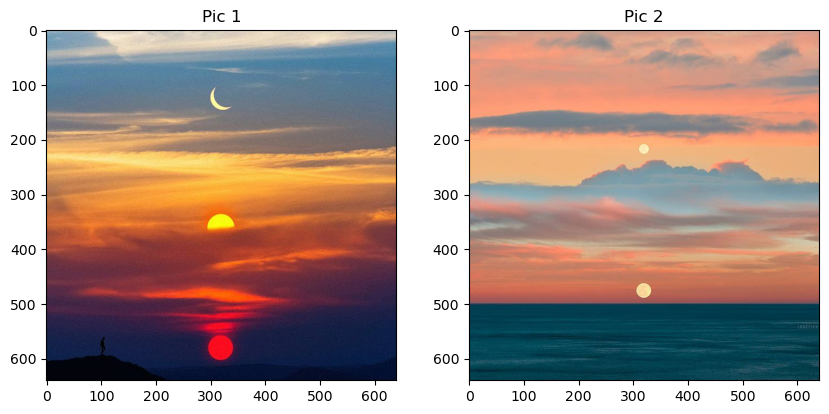

In [6]:
# Visually Compare the two images
plt.figure(figsize=(10,10))

plt.subplot(2,2,1)
plt.imshow(get_image(key1),cmap=plt.cm.binary)
plt.title('Pic 1');

plt.subplot(2,2,2)
plt.imshow(get_image(key2),cmap=plt.cm.binary)
plt.title('Pic 2');

In [7]:
# Get similarity score function
def get_image_similarity(imgEmbedFrame,imgIndexB,imgIndexA=0):
    return sum(imgEmbedFrame.iloc[imgIndexA][:-6] * imgEmbedFrame.iloc[imgIndexB][:-6]) 
    

In [8]:
# Add similarity score to dataframe
for i in range(len(imgVectorFrame)):
    imgVectorFrame['Similarity_To_Index_0'].at[i] = get_image_similarity(imgVectorFrame,i)

In [9]:
# Save top 5000 similar images, with respect to index 0
training_set = imgVectorFrame.nlargest(5000,'Similarity_To_Index_0')
training_set.to_csv('collage_gan_training_data.csv')